# Example Brahe Notebook

This is an example notebook on how to use the Brahe library.

To get started install the following python packages:

```bash
pip install git+https://github.com/duncaneddy/brahe.git@master matplotlib ipympl cartopy
```

In [1]:
# Here we import our desired packages

import warnings
import math
import numpy as np

# Plotting Imports
import shapely
import cartopy.crs as ccrs
import cartopy.geodesic
import matplotlib.pyplot as plt

# Brahe Imports
import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba

# Cartopy generates a bunch of warnings that are not useful so we suppress them

APPLIED_FILTER_WARNINGS = False

def filter_cartopy_warnings():
    global APPLIED_FILTER_WARNINGS

    if not APPLIED_FILTER_WARNINGS:
        warnings.filterwarnings("ignore", message="Approximating coordinate system")
        APPLIED_FILTER_WARNINGS = True

filter_cartopy_warnings()

In [2]:
# Here we define the Moneky-patch for the ECI to ECEF conversion

# Monkey Patch ECI -> ECEF transformation due to segfault in upstream dependency
# This changes the transformation to only consider the Earth's rotation and not the polar motion, precession, or nutation
# This is a simplification but is sufficient for this use case
def sECEFtoECIpatch(epc, x):
    """Transforms an Earth fixed state into an Inertial state

    The transformation is accomplished using the IAU 2006/2000A, CIO-based
    theory using classical angles. The method as described in section 5.5 of
    the SOFA C transformation cookbook.

    Args:
        epc (Epoch): Epoch of transformation
        x (np.ndarray): Earth-fixed state (position, velocity) [*m*; *m/s*]

    Returns:
        x_ecef (np.ndarray): Inertial state (position, velocity)
    """

    # Ensure input is array-like
    x = np.asarray(x)

    # Set state variable size
    dim_x = len(x)
    x_eci = np.zeros((dim_x,))

    # Extract State Components
    r_ecef = x[0:3]

    if dim_x >= 6:
        v_ecef = x[3:6]

    # Compute Sequential Transformation Matrices
    rot = bh.earth_rotation(epc)

    # Create Earth's Angular Rotation Vector
    omega_vec = np.array([0, 0, bh.constants.OMEGA_EARTH]) # Neglect LOD effect

    # Calculate ECEF State
    x_eci[0:3] = ( rot ).T @ r_ecef
    # x_eci[0:3] = (pm @ rot @ bpn).T @ r_ecef

    if dim_x >= 6:
        x_eci[3:6] = (rot ).T @ (v_ecef + bh.utils.fcross(omega_vec, r_ecef))

    return x_eci

bh.frames.sECEFtoECI = sECEFtoECIpatch

In [4]:
# Here we can download the latest Earth orientation data and load it.

# Uncomment this line ONCE the data has been downloaded. Recomment it once it has been downloaded.
# bh.utils.download_iers_bulletin_ab()

# Load the latest Earth Orientation Data
bh.EOP.load('iau2000A_finals_ab.txt')

In [5]:
# Working with Time

# Brahe uses the `Epoch` class to represent time. It operates incredibly similarly to the `Epoch` class of `SatelliteDynamics.jl` in Julia.

# Define a new Epoch
epc = bh.Epoch(2021, 1, 1, 0, 0, 0)

print(f'Epoch: {epc}')

# We can also add time to an epoch. The time is always in seconds.

epc += 86400

print(f'Epoch One Day Later: {epc}')

Epoch: 2021-01-01 00:00:00.000 UTC
Epoch One Day Later: 2021-01-02 00:00:00.000 UTC


In [6]:
# Working with Satellite State

# The TLE is likely the most accessible way for you to propagate the satellite state. Brahe has a built-in TLE parser that can be used to load TLEs from lines. 
# However to make it easier, we define a function to create a TLE from orbital elements.

def get_tle(epc0, alt, ecc, inc, raan, argp, M, ndt2=0.0, nddt6=0.0, bstar=0.0, norad_id=99999):
    '''Get a TLE object from the given orbital elements

    Args:
    - epc0 (Epoch): Epoch of the orbital elements / state
    - alt (float): Altitude of the orbit [km]
    - ecc (float): Eccentricity of the orbit
    - inc (float): Inclination of the orbit [deg]
    - raan (float): Right Ascension of the Ascending Node [deg]
    - argp (float): Argument of Perigee [deg]
    - M (float): Mean Anomaly [deg]

    Returns:
    - tle (TLE): TLE object for the given orbital elements
    '''

    alt *= 1e3 # Convert to meters

    # Get semi-major axis
    sma = bh.R_EARTH + alt

    # Get mean motion
    n = bh.mean_motion(sma)/(2*np.pi)*86400

    tle_string = bh.tle_string_from_elements(epc0, np.array([n, ecc, inc, raan, argp, M, ndt2, nddt6, bstar]), norad_id)
    tle = bh.TLE(*tle_string)
    return tle

# Now we can create a TLE

epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # This is the epoch of the orbital elements
alt  = 550 # Altitude in km
ecc  = 0.01 # Eccentricity - Generally don't want it to be 0, so give it a small value 0.0001 to 0.01
inc  = 53 # Inclination in degrees
raan = 15 # Right Ascension of the Ascending Node in degrees
argp = 30 # Argument of Perigee in degrees
M    = 45 # Mean Anomaly in degrees
norad_id = 99999 # NORAD ID of the satellite - This is just a placeholder, but we need a number.

tle = get_tle(epc0, alt, ecc, inc, raan, argp, M, norad_id=norad_id)

print(f'Our TLE looks like:\n {tle.line1}\n {tle.line2}\n')

# We can now use the TLE to get the state at different epochs.

t = epc0 + 86400 # One day later
x_eci = tle.state_eci(t) # Get the ECI state one day later
print(f'ECI State at {t}:\n{x_eci}\n')

x_ecef = tle.state_ecef(t) # Get the ECEF state one day later
print(f'ECEF State at {t}:\n{x_ecef}\n')

# Get the Lat Lon Alt of the satellite
x_geod = bh.sECEFtoGEOD(x_ecef[0:3], use_degrees=True) # Need the array slice to get only the position
print(f'Lat Lon Alt at {t}: Lon: {x_geod[0]:.2f} Lat: {x_geod[1]:.2f} Alt (m): {x_geod[2]:.2f}\n')

Our TLE looks like:
 1 99999U          24141.00000000  .00000000  00000-0  00000-0 0    00
 2 99999  53.0000  15.0000 0100000  30.0000  45.0000 15.05490874    07

ECI State at 2024-05-21 00:00:00.000 UTC:
[-1.76849605e+06  3.84803322e+06  5.43757951e+06 -7.30514027e+03
 -1.98709720e+03 -8.79838269e+02]

ECEF State at 2024-05-21 00:00:00.000 UTC:
[-2.37634326e+06 -3.50541447e+06  5.43757951e+06  5.22684124e+03
 -5.04746722e+03 -8.79838269e+02]

Lat Lon Alt at 2024-05-21 00:00:00.000 UTC: Lon: -124.13 Lat: 52.26 Alt (m): 527381.02



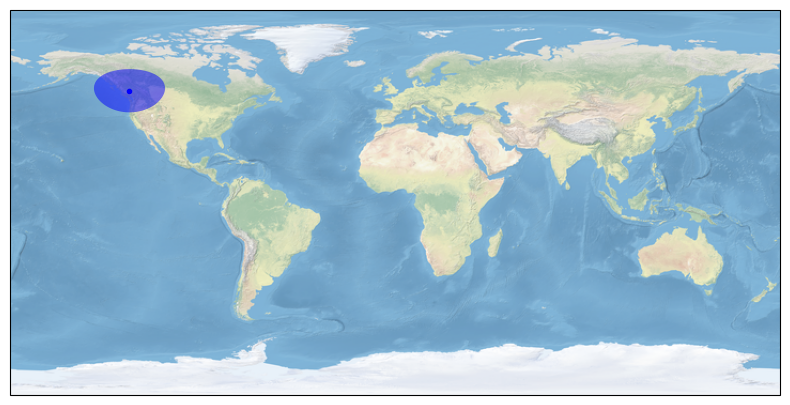

In [7]:
# Now we want to play around with some plotting

def compute_earth_interior_angle(ele=0.0, alt=525):
    '''This function computes the earth interior angle for a given elevation angle and altitude.
    This is the angle between the satellite and the observer on the Earth's surface viewing the satellite
    at the given elevation angle. This is more useful for plotting than the look angle, since it
    can used alonside Earth's Radius to draw a circle around the subsatellite point to get
    the view cone of observers on the Earth's surface that would be able to see the satellite.


    Args:
    - ele (float): Elevation angle of the satellite [deg]
    - alt (float): Altitude of the satellite [km]

    '''
    ele = ele * math.pi / 180.0

    rho = math.asin(bh.R_EARTH/(bh.R_EARTH + alt * 1e3))

    eta = math.asin(math.cos(ele)*math.sin(rho))
    lam = math.pi/2.0 - eta - ele

    return lam

# Now we can plot what a satellite can see from a given altitude
# Let's say we want to see what a satellite at 525 km can see if all observers
# are looking at it with at least 20 degrees elevation angle. This is an appropriate
# Value for a communications (Starlink/Kuiper) user terminal. If you wanted to get
# the maximum possible coverage limited by the Earth's curvature, you would use 0 degrees.

elevation_min = 20.0
lam = compute_earth_interior_angle(ele=elevation_min, alt=alt)

# Get the satellite position from above
x_ecef = tle.state_ecef(t) # Get the ECEF state one day later
x_geod = bh.sECEFtoGEOD(x_ecef[0:3], use_degrees=True) # Need the array slice to get only the position
lon, lat = x_geod[0], x_geod[1]

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.stock_img()
c = 'b' # Set the plot color

# Plot Groundstation Location
ax.plot(lon, lat, color=c, marker='o', markersize=3, transform=ccrs.Geodetic())

# Get a bunch of points in a circle space at the the right angle offset from the sub-satellite point to draw the view cone
circle_points = cartopy.geodesic.Geodesic().circle(lon=lon, lat=lat, radius=lam*bh.R_EARTH, n_samples=100, endpoint=False)
geom = shapely.geometry.Polygon(circle_points)
ax.add_geometries((geom,), crs=ccrs.Geodetic(), facecolor=c, alpha=0.5, edgecolor='none', linewidth=0)

plt.show()